<a href="https://colab.research.google.com/github/BrunoEMendes/Network-Modeling/blob/master/Routing_Modela%C3%A7%C3%A3o_de_Redes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP4 ROUTING

<h3>Modelação de Redes </h3>
Autor: Bruno Mendes

<a type=email> a62181@ualg.pt</a>

## Objectivo:

Implementar as formalizações dos problemas de routing:
- Caminho individual mais curto (OSPF/Dijkstra)
- Caminho global mais curto considerando um caminho unico por cada par destino

## Código

### Input


O input foi baseado no seguinte esquema:

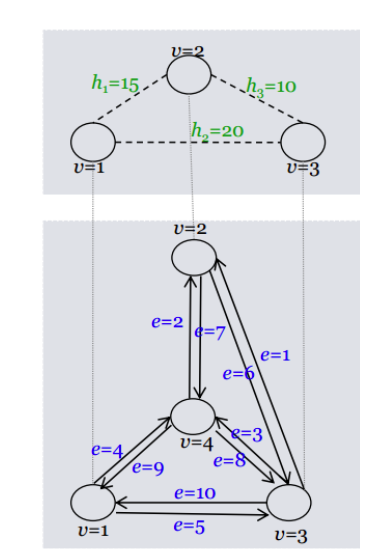


imagem retirada de https://tutoria.ualg.pt/2020/pluginfile.php/107278/mod_resource/content/2/Part2.pdf

Também existe um caminho teste entre 1-2 com capacidade 3 e uma demanda 1_2 para testes

Apesar dos custos e das demandas não serem utilizadas neste exercicio, estas são colocadas de forma a permitir a reutilização do código


As variáveis utilizadas têm o seguinte formato:

X\<id\_da\_demanda\>,\<link\_nó inicial\>_\<link\_nó final>

In [1]:
n_nodes = 4

#structure id: from_node, to_node, demand_cost
# para este caso assume-se que as demandas sao sempre 1
demands = {
  '1': [1, 2, 15],
  '2': [1, 3, 20],
  '3': [2, 3, 10],
  #'4': [1, 2, 20],
  #'5': [1, 2, 10]   
}

# structure id: from_node, to_node, link_cost
links = {
    '1': [3, 2, 1],
    '2': [4, 2, 3],
    '3': [3, 4, 1],
    '4': [1, 4, 2],
    '5': [1, 3, 1],
    '6': [2, 3, 1],
    '7': [2, 4, 3],
    '8': [4, 3, 1],
    '9': [4, 1, 2],
    '10': [3,1, 4],
    #'11': [1, 2, 3]
}

# structure id: {path_id : [links]}
paths = {
    '1': {
        '1_1': [2, 4],
        '1_2': [1, 5]
    },
    '2': {
        '2_1': [5]
    },
    '3':{
        '3_1': [1]
    }
}

print('number of nodes: ', n_nodes)
print('number of demands: ', len(demands))
print('number of links: ', len(links))
print('number of paths: ', len(paths))

number of nodes:  4
number of demands:  3
number of links:  10
number of paths:  3


### Nodes

In [2]:
class Node:
  def __init__(self, id):
    self.id = id

  def __str__(self):
    return f'Node id: {self.id}'
    
  def get_id(self):
    return self.id

  def is_id(self, id):
    return int(self.id) == int(id)

node_list = [Node(id) for id in range(1, n_nodes + 1)]
print([str(n) for n in node_list])

['Node id: 1', 'Node id: 2', 'Node id: 3', 'Node id: 4']


### Demands

In [3]:
class Demand:
  def __init__(self, id, from_node: Node, to_node: Node, h_demand):
    self.id = id
    self.from_node = from_node
    self.to_node = to_node
    self.h_demand = h_demand
  

  def __str__(self):
    return f'Demand {self.id}: {self.from_node} -> {self.to_node} | h {self.h_demand}'

  def h_demand(self):
    return self.h_demand

def get_node_id(node_list, node):
  return [n for n in node_list if n.is_id(node)]

## BUILD DEMAND LIST
demand_list = []
for k, v in demands.items():
  node_from = get_node_id(node_list, v[0])[0]
  node_to = get_node_id(node_list, v[1])[0]
  demand_list.append(Demand(k, node_from, node_to, v[2]))

for d in demand_list:
  print(d)


Demand 1: Node id: 1 -> Node id: 2 | h 15
Demand 2: Node id: 1 -> Node id: 3 | h 20
Demand 3: Node id: 2 -> Node id: 3 | h 10


### Links

In [4]:
class Link:
  def __init__(self, id, from_node, to_node, cost):
    self.id = id
    self.from_node = from_node
    self.to_node = to_node
    self.cost = cost

  def __str__(self):
    return f'Link {self.id}: {self.from_node} -> {self.to_node} | link cost: {self.cost}'
  
  def is_id(self, id):
    return int(self.id) == int(id)

  def from_node():
    return self.from_node.get_id()

  def to_node():
    return self.to_node.get_id()

  def get_w():
    return self.w

  def cost():
    return self.cost

# BUILD LINK LIST
link_list = []
for k, v in links.items():
  node_from = get_node_id(node_list, v[0])[0]
  node_to = get_node_id(node_list, v[1])[0]
 
  link_list.append(Link(k, node_from, node_to, v[2]))

for l in link_list:
  print(l)

Link 1: Node id: 3 -> Node id: 2 | link cost: 1
Link 2: Node id: 4 -> Node id: 2 | link cost: 3
Link 3: Node id: 3 -> Node id: 4 | link cost: 1
Link 4: Node id: 1 -> Node id: 4 | link cost: 2
Link 5: Node id: 1 -> Node id: 3 | link cost: 1
Link 6: Node id: 2 -> Node id: 3 | link cost: 1
Link 7: Node id: 2 -> Node id: 4 | link cost: 3
Link 8: Node id: 4 -> Node id: 3 | link cost: 1
Link 9: Node id: 4 -> Node id: 1 | link cost: 2
Link 10: Node id: 3 -> Node id: 1 | link cost: 4


### Paths

In [5]:
print(paths)

class Route:
  def __init__(self, id, link_collection):
    self.id = id
    self.link_collection = link_collection
  
  def __str__(self):
    return f'Route {self.id}: ' + ' '.join(['[ ' + str(l) + ' ]' for l in self.link_collection])

  def get_links(self):
    return self.link_collection


class Path:
  def __init__(self, id, path_list, link_list):
    self.id = id
    self.path_list = self.__gen_path_list(path_list, link_list)

  def __str__(self):
    return f'Path {self.id} | Routes :' + ' '.join(['{ ' + str(r) + ' }' for r in self.path_list])

  def __get_link(self, link_id, link_list):
    try:
      return [l for l in link_list if l.is_id(link_id)][0]
    except:
      raise Exception('bad format')

  def __gen_path_list(self, path_list, link_list):
    link_collection = []
    for p in path_list:
      link_tmp = []
      for l in path_list[p]:
        link_tmp.append(self.__get_link(l, link_list))
      link_collection.append(Route(p, link_tmp))
    return link_collection

  def get_paths(self):
    return self.path_list




route_list = [Path(k, v, link_list) for k,v in paths.items()]
for r in route_list:
  print(r)

{'1': {'1_1': [2, 4], '1_2': [1, 5]}, '2': {'2_1': [5]}, '3': {'3_1': [1]}}
Path 1 | Routes :{ Route 1_1: [ Link 2: Node id: 4 -> Node id: 2 | link cost: 3 ] [ Link 4: Node id: 1 -> Node id: 4 | link cost: 2 ] } { Route 1_2: [ Link 1: Node id: 3 -> Node id: 2 | link cost: 1 ] [ Link 5: Node id: 1 -> Node id: 3 | link cost: 1 ] }
Path 2 | Routes :{ Route 2_1: [ Link 5: Node id: 1 -> Node id: 3 | link cost: 1 ] }
Path 3 | Routes :{ Route 3_1: [ Link 1: Node id: 3 -> Node id: 2 | link cost: 1 ] }


In [6]:
for r in route_list:
  for p in r.get_paths():
    print(p)

Route 1_1: [ Link 2: Node id: 4 -> Node id: 2 | link cost: 3 ] [ Link 4: Node id: 1 -> Node id: 4 | link cost: 2 ]
Route 1_2: [ Link 1: Node id: 3 -> Node id: 2 | link cost: 1 ] [ Link 5: Node id: 1 -> Node id: 3 | link cost: 1 ]
Route 2_1: [ Link 5: Node id: 1 -> Node id: 3 | link cost: 1 ]
Route 3_1: [ Link 1: Node id: 3 -> Node id: 2 | link cost: 1 ]


### Single Shortest Path Djisktra

Flow Conservation Law


$ \displaystyle{\sum_{e:src(e) = v} x_{d,e}} - \displaystyle{\sum_{e:src(e) = v} x_{d,e}} = \begin{cases}
  h_d, & \mbox{if } v\mbox{ = src(d) } \\
 -h_d, & \mbox{if } v\mbox{ = dst(d) }\\
 0, & otherwise 
\end{cases}, d = 1,2,...D$

In [7]:
res_from = []
res_to = []
res_neutral = []
var_list = []


for d in demand_list:
  for n in node_list:
    tmp_from = []
    tmp_to = []
    tmp_neutral = []
    for l in link_list:
      _var = f'X{d.id},{l.from_node.get_id()}_{l.to_node.get_id()}'
      if n == d.from_node:
        if d.from_node == l.from_node:
          tmp_from.append(' + '+ _var)
        elif d.from_node == l.to_node:
          tmp_from.append(' - '+ _var)
      elif n == d.to_node:
        if d.to_node == l.from_node:
          tmp_to.append(' + '+ _var)
        elif d.to_node == l.to_node:
          tmp_to.append(' - '+ _var)
      else:
        if n == l.from_node:
          tmp_neutral.append(' + '+ _var)
        elif n == l.to_node:
          tmp_neutral.append(' - '+ _var)
      if _var not in var_list:
        var_list.append(_var)
    if n == d.from_node:
      res_from.append(''.join(tmp_from) + f' = 1')
    elif n == d.to_node:
      res_to.append(''.join(tmp_to) + f' = -1')
    else:
      res_neutral.append(''.join(tmp_neutral) + ' = 0')
print('from:    ', res_from)
print('to:      ', res_to)
print('neutral: ', res_neutral)
print('vars:    ', var_list)

from:     [' + X1,1_4 + X1,1_3 - X1,4_1 - X1,3_1 = 1', ' + X2,1_4 + X2,1_3 - X2,4_1 - X2,3_1 = 1', ' - X3,3_2 - X3,4_2 + X3,2_3 + X3,2_4 = 1']
to:       [' - X1,3_2 - X1,4_2 + X1,2_3 + X1,2_4 = -1', ' + X2,3_2 + X2,3_4 - X2,1_3 - X2,2_3 - X2,4_3 + X2,3_1 = -1', ' + X3,3_2 + X3,3_4 - X3,1_3 - X3,2_3 - X3,4_3 + X3,3_1 = -1']
neutral:  [' + X1,3_2 + X1,3_4 - X1,1_3 - X1,2_3 - X1,4_3 + X1,3_1 = 0', ' + X1,4_2 - X1,3_4 - X1,1_4 - X1,2_4 + X1,4_3 + X1,4_1 = 0', ' - X2,3_2 - X2,4_2 + X2,2_3 + X2,2_4 = 0', ' + X2,4_2 - X2,3_4 - X2,1_4 - X2,2_4 + X2,4_3 + X2,4_1 = 0', ' + X3,1_4 + X3,1_3 - X3,4_1 - X3,3_1 = 0', ' + X3,4_2 - X3,3_4 - X3,1_4 - X3,2_4 + X3,4_3 + X3,4_1 = 0']
vars:     ['X1,3_2', 'X1,4_2', 'X1,3_4', 'X1,1_4', 'X1,1_3', 'X1,2_3', 'X1,2_4', 'X1,4_3', 'X1,4_1', 'X1,3_1', 'X2,3_2', 'X2,4_2', 'X2,3_4', 'X2,1_4', 'X2,1_3', 'X2,2_3', 'X2,2_4', 'X2,4_3', 'X2,4_1', 'X2,3_1', 'X3,3_2', 'X3,4_2', 'X3,3_4', 'X3,1_4', 'X3,1_3', 'X3,2_3', 'X3,2_4', 'X3,4_3', 'X3,4_1', 'X3,3_1']


**Função Mimizante**

$Minimize \quad F = \displaystyle{\sum_d}\displaystyle{\sum_e}x_{d,e}$



In [8]:
# isto serve para remover as repetições
var_list = list(set(var_list))
print('Lista de vars')
print(var_list)

Lista de vars
['X1,4_3', 'X2,1_3', 'X2,2_3', 'X1,1_3', 'X3,1_3', 'X1,3_1', 'X2,4_2', 'X2,3_4', 'X3,4_3', 'X2,2_4', 'X2,3_2', 'X1,4_2', 'X2,3_1', 'X1,2_4', 'X3,4_2', 'X3,3_4', 'X1,3_4', 'X2,4_1', 'X3,2_4', 'X1,1_4', 'X2,4_3', 'X3,3_1', 'X1,2_3', 'X1,3_2', 'X3,4_1', 'X1,4_1', 'X3,3_2', 'X2,1_4', 'X3,1_4', 'X3,2_3']


**Ficheiro LP**

- funcão de minimizar
- lei da conservação
- restrições

In [9]:
print('minimize ' + ' + '.join(m for m in var_list))
print('subject to')
for var in res_from:
  print(var)
for var in res_to:
  print(var)
for var in res_neutral:
  print(var)
print('bounds')
for m in var_list:
  print(f'{m} >= 0')

print('end')


minimize X1,4_3 + X2,1_3 + X2,2_3 + X1,1_3 + X3,1_3 + X1,3_1 + X2,4_2 + X2,3_4 + X3,4_3 + X2,2_4 + X2,3_2 + X1,4_2 + X2,3_1 + X1,2_4 + X3,4_2 + X3,3_4 + X1,3_4 + X2,4_1 + X3,2_4 + X1,1_4 + X2,4_3 + X3,3_1 + X1,2_3 + X1,3_2 + X3,4_1 + X1,4_1 + X3,3_2 + X2,1_4 + X3,1_4 + X3,2_3
subject to
 + X1,1_4 + X1,1_3 - X1,4_1 - X1,3_1 = 1
 + X2,1_4 + X2,1_3 - X2,4_1 - X2,3_1 = 1
 - X3,3_2 - X3,4_2 + X3,2_3 + X3,2_4 = 1
 - X1,3_2 - X1,4_2 + X1,2_3 + X1,2_4 = -1
 + X2,3_2 + X2,3_4 - X2,1_3 - X2,2_3 - X2,4_3 + X2,3_1 = -1
 + X3,3_2 + X3,3_4 - X3,1_3 - X3,2_3 - X3,4_3 + X3,3_1 = -1
 + X1,3_2 + X1,3_4 - X1,1_3 - X1,2_3 - X1,4_3 + X1,3_1 = 0
 + X1,4_2 - X1,3_4 - X1,1_4 - X1,2_4 + X1,4_3 + X1,4_1 = 0
 - X2,3_2 - X2,4_2 + X2,2_3 + X2,2_4 = 0
 + X2,4_2 - X2,3_4 - X2,1_4 - X2,2_4 + X2,4_3 + X2,4_1 = 0
 + X3,1_4 + X3,1_3 - X3,4_1 - X3,3_1 = 0
 + X3,4_2 - X3,3_4 - X3,1_4 - X3,2_4 + X3,4_3 + X3,4_1 = 0
bounds
X1,4_3 >= 0
X2,1_3 >= 0
X2,2_3 >= 0
X1,1_3 >= 0
X3,1_3 >= 0
X1,3_1 >= 0
X2,4_2 >= 0
X2,3_4 >= 0
X3,4_3

**Análise dos Resultados do CPLEX**

Variable Name           Solution Value

X2,1_3                        1.000000

X1,3_2                        1.000000

X1,1_3                        1.000000

X3,2_3                        1.000000

O Caminho mais curto para a demanda 1 é {1_4, 4_2}, para a demanda 2 é {1_3} e 3 é {2_3}

Caso também esteja incluido o link 11 (caminho entre 1-2) a solução é:

Variable Name           Solution Value

X2,1_3                        1.000000

X1,1_2                        1.000000

X3,2_3                        1.000000

O caminho mais curta para a demanda 1 passa a ser {1_2}

### Global Shortest Path Routing

A formação da estrutura é semelhante, a única diferença é que temos de considerar a restrição de capacidade para os links

Para tal temos que garantir que o número de demandas que passa nesse link não excede o limite desse link

Se quisermos garantir que esse link é apenas utilizado por uma e só uma demanda basta colocar o seu custo  = 1


**Limite de Capacidade:** $\displaystyle{\sum_d}X_{d,e} \leq c_e, e = 1, 2,..., E$




In [10]:
res_from = []
res_to = []
res_neutral = []
var_list = []

# O código é exatamente igual, só que agora queremos guardar as variáveis e as restrições de capacidade associadas
restrictions = {}
for d in demand_list:
  for n in node_list:
    tmp_from = []
    tmp_to = []
    tmp_neutral = []
    for l in link_list:
      _var = f'X{d.id},{l.from_node.get_id()}_{l.to_node.get_id()}'


      # alteração de código aqui
      # isto junta todos as variáveis associadas a um certo link
      if f'{l.from_node.get_id()}_{l.to_node.get_id()}' not in restrictions:
        # como queremos caminho único, o valor aqui será 1
        restrictions[f'{l.from_node.get_id()}_{l.to_node.get_id()}'] = [1]
      elif _var not in restrictions[f'{l.from_node.get_id()}_{l.to_node.get_id()}']:
        restrictions[f'{l.from_node.get_id()}_{l.to_node.get_id()}'].append(_var)
        

      if n == d.from_node:
        if d.from_node == l.from_node:
          tmp_from.append(' + '+ _var)
        elif d.from_node == l.to_node:
          tmp_from.append(' - '+ _var)
      elif n == d.to_node:
        if d.to_node == l.from_node:
          tmp_to.append(' + '+ _var)
        elif d.to_node == l.to_node:
          tmp_to.append(' - '+ _var)
      else:
        if n == l.from_node:
          tmp_neutral.append(' + '+ _var)
        elif n == l.to_node:
          tmp_neutral.append(' - '+ _var)
      if _var not in var_list:
        var_list.append(_var)
    if n == d.from_node:
      res_from.append(''.join(tmp_from) + f' = 1')
    elif n == d.to_node:
      res_to.append(''.join(tmp_to) + f' = -1')
    else:
      res_neutral.append(''.join(tmp_neutral) + ' = 0')
print('from:        ', res_from)
print('to:          ', res_to)
print('neutral:     ', res_neutral)
print('vars:        ', var_list)
print('restrictions:', restrictions)


from:         [' + X1,1_4 + X1,1_3 - X1,4_1 - X1,3_1 = 1', ' + X2,1_4 + X2,1_3 - X2,4_1 - X2,3_1 = 1', ' - X3,3_2 - X3,4_2 + X3,2_3 + X3,2_4 = 1']
to:           [' - X1,3_2 - X1,4_2 + X1,2_3 + X1,2_4 = -1', ' + X2,3_2 + X2,3_4 - X2,1_3 - X2,2_3 - X2,4_3 + X2,3_1 = -1', ' + X3,3_2 + X3,3_4 - X3,1_3 - X3,2_3 - X3,4_3 + X3,3_1 = -1']
neutral:      [' + X1,3_2 + X1,3_4 - X1,1_3 - X1,2_3 - X1,4_3 + X1,3_1 = 0', ' + X1,4_2 - X1,3_4 - X1,1_4 - X1,2_4 + X1,4_3 + X1,4_1 = 0', ' - X2,3_2 - X2,4_2 + X2,2_3 + X2,2_4 = 0', ' + X2,4_2 - X2,3_4 - X2,1_4 - X2,2_4 + X2,4_3 + X2,4_1 = 0', ' + X3,1_4 + X3,1_3 - X3,4_1 - X3,3_1 = 0', ' + X3,4_2 - X3,3_4 - X3,1_4 - X3,2_4 + X3,4_3 + X3,4_1 = 0']
vars:         ['X1,3_2', 'X1,4_2', 'X1,3_4', 'X1,1_4', 'X1,1_3', 'X1,2_3', 'X1,2_4', 'X1,4_3', 'X1,4_1', 'X1,3_1', 'X2,3_2', 'X2,4_2', 'X2,3_4', 'X2,1_4', 'X2,1_3', 'X2,2_3', 'X2,2_4', 'X2,4_3', 'X2,4_1', 'X2,3_1', 'X3,3_2', 'X3,4_2', 'X3,3_4', 'X3,1_4', 'X3,1_3', 'X3,2_3', 'X3,2_4', 'X3,4_3', 'X3,4_1', 'X3,3_1']
r

**Ficheiro LP**

Também semelhante ao anterior só que agora consideram-se as capacidades dos links


In [11]:
var_list = list(set(var_list))
print('minimize ' + ' + '.join(m for m in var_list))
print('subject to')
for var in res_from:
  print(var)
for var in res_to:
  print(var)
for var in res_neutral:
  print(var)
# a alteração acontece aqui, adicionamos as restrições
for var in restrictions:
  print(' + '.join([value for value in restrictions[var][1:]])  + f' <= {restrictions[var][0]}')
print('bounds')
for m in var_list:
  print(f'{m} >= 0')

print('end')

minimize X1,4_3 + X2,1_3 + X2,2_3 + X1,1_3 + X3,1_3 + X1,3_1 + X2,4_2 + X2,3_4 + X3,4_3 + X2,2_4 + X2,3_2 + X1,4_2 + X2,3_1 + X1,2_4 + X3,4_2 + X3,3_4 + X1,3_4 + X2,4_1 + X3,2_4 + X1,1_4 + X2,4_3 + X3,3_1 + X1,2_3 + X1,3_2 + X3,4_1 + X1,4_1 + X3,3_2 + X2,1_4 + X3,1_4 + X3,2_3
subject to
 + X1,1_4 + X1,1_3 - X1,4_1 - X1,3_1 = 1
 + X2,1_4 + X2,1_3 - X2,4_1 - X2,3_1 = 1
 - X3,3_2 - X3,4_2 + X3,2_3 + X3,2_4 = 1
 - X1,3_2 - X1,4_2 + X1,2_3 + X1,2_4 = -1
 + X2,3_2 + X2,3_4 - X2,1_3 - X2,2_3 - X2,4_3 + X2,3_1 = -1
 + X3,3_2 + X3,3_4 - X3,1_3 - X3,2_3 - X3,4_3 + X3,3_1 = -1
 + X1,3_2 + X1,3_4 - X1,1_3 - X1,2_3 - X1,4_3 + X1,3_1 = 0
 + X1,4_2 - X1,3_4 - X1,1_4 - X1,2_4 + X1,4_3 + X1,4_1 = 0
 - X2,3_2 - X2,4_2 + X2,2_3 + X2,2_4 = 0
 + X2,4_2 - X2,3_4 - X2,1_4 - X2,2_4 + X2,4_3 + X2,4_1 = 0
 + X3,1_4 + X3,1_3 - X3,4_1 - X3,3_1 = 0
 + X3,4_2 - X3,3_4 - X3,1_4 - X3,2_4 + X3,4_3 + X3,4_1 = 0
X1,3_2 + X2,3_2 + X3,3_2 <= 1
X1,4_2 + X2,4_2 + X3,4_2 <= 1
X1,3_4 + X2,3_4 + X3,3_4 <= 1
X1,1_4 + X2,1_4 + X

**Análise dos Resultados do CPLEX**


Variable Name           Solution Value

X2,1_3                        1.000000

X1,4_2                        1.000000

X1,1_4                        1.000000

X3,2_3                        1.000000

Como esperado os valores são iguais para todas as demandas em relação ao primeiro, visto que os caminhos são unicos para todas das demandas

No entanto, quando se adicionando outra demanda de 1_2 (neste caso representada com a label 4) vai ser obrigada a seguir um caminho diferente da demanda representada com a label 1:

Variable Name           Solution Value
X2,1_3                        1.000000

X1,3_2                        1.000000

X1,1_3                        1.000000

X4,1_4                        1.000000

X4,4_2                        1.000000

X3,2_3                        1.000000

Neste caso a demanda 1 irá por {1_3} e {3_2} enquanto a demanda 4 irá por {1_4} e {4_2}

Se adicionarmos uma terceira demanda de 1_2 neste exemplo, iremos obter resultados que não fazem sentido visto que apenas existem 2 caminhos entre 1_2

Variable Name           Solution Value

X2,1_3                        1.000000

X1,3_2                        2.000000

X1,4_2                       -1.000000**

X1,1_3                        2.000000

X1,1_4                       -1.000000**

X4,1_4                        1.000000

X4,4_2                        1.000000

X5,3_2                       -1.000000**

X5,4_2                        2.000000

X5,1_4                        1.000000
